In [1]:
!pip install -e ../..

Obtaining file:///home/egor/Documents/FCApy
  Attempting uninstall: fcapy
    Found existing installation: fcapy 0.1.2
    Uninstalling fcapy-0.1.2:
      Successfully uninstalled fcapy-0.1.2
  Running setup.py develop for fcapy


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re

In [3]:
from fcapy.context import FormalContext
from fcapy.lattice import ConceptLattice
from fcapy.visualizer import ConceptLatticeVisualizer, POSetVisualizer

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# 1. Motivation

?

# 2. Introduction to FCA

## 2.1 Formal context

In [5]:
K = FormalContext.from_csv('../../data/mango_bin.csv')
K_df = K.to_pandas()
K_df = K_df[['color_is_yellow', 'color_is_green', 'color_is_blue', 'color_is_white', 'form_is_round', 'form_is_oval', 'form_is_cubic', 'firm', 'smooth', 'fruit']]
K_df

,color_is_yellow,color_is_green,color_is_blue,color_is_white,form_is_round,form_is_oval,form_is_cubic,firm,smooth,fruit
apple,True,False,False,False,True,False,False,False,True,True
grapefruit,True,False,False,False,True,False,False,False,False,True
kiwi,False,True,False,False,False,True,False,False,False,True
plum,False,False,True,False,False,True,False,False,True,True
toy cube,False,True,False,False,False,False,True,True,True,False
egg,False,False,False,True,False,True,False,True,True,False
tennis ball,False,False,False,True,True,False,False,False,False,False
mango,False,True,False,False,False,True,False,False,True,True


In [6]:
K_df.columns = pd.MultiIndex.from_tuples([f.split('_is_') if '_is_' in f else (f, '') for f in K_df.columns])
K_df = K_df.replace({True: 'X', False:''})
K_df['fruit'] = K_df['fruit'].replace({'X':1, '':0})

In [7]:
print(K_df.to_latex())

\begin{tabular}{llllllllllr}
\toprule
{} & \multicolumn{4}{l}{color} & \multicolumn{3}{l}{form} & firm & smooth & fruit \\
{} & yellow & green & blue & white & round & oval & \multicolumn{4}{l}{cubic} \\
\midrule
apple       &      X &       &      &       &     X &      &       &      &      X &     1 \\
grapefruit  &      X &       &      &       &     X &      &       &      &        &     1 \\
kiwi        &        &     X &      &       &       &    X &       &      &        &     1 \\
plum        &        &       &    X &       &       &    X &       &      &      X &     1 \\
toy cube    &        &     X &      &       &       &      &     X &    X &      X &     0 \\
egg         &        &       &      &     X &       &    X &       &    X &      X &     0 \\
tennis ball &        &       &      &     X &     X &      &       &      &        &     0 \\
mango       &        &     X &      &       &       &    X &       &      &      X &     1 \\
\bottomrule
\end{tabular}



In [8]:
K_df

color                   form            firm smooth fruit
            yellow green blue white round oval cubic                  
apple            X                      X                      X     1
grapefruit       X                      X                            1
kiwi                   X                     X                       1
plum                        X                X                 X     1
toy cube               X                           X    X      X     0
egg                               X          X          X      X     0
tennis ball                       X     X                            0
mango                  X                     X                 X     1

In [9]:
K_X = K.from_pandas(K.to_pandas().drop('fruit',1))

In [10]:
K_X_df = K_X.to_pandas()
K_X_dich = K_X_df.copy()
for f in list(K_X_dich.columns):
    K_X_dich[f'not_{f}'] = ~K_X_dich[f]
K_X_dich = FormalContext.from_pandas(K_X_dich)
K_X_dich

FormalContext (8 objects, 18 attributes, 72 connections)
           |firm|smooth|color_is_yellow|color_is_green|color_is_blue|...|not_color_is_blue|not_color_is_white|not_form_is_round|not_form_is_oval|not_form_is_cubic|
apple      |    |     X|              X|              |             |...|                X|                 X|                 |               X|                X|
grapefruit |    |      |              X|              |             |...|                X|                 X|                 |               X|                X|
kiwi       |    |      |               |             X|             |...|                X|                 X|                X|                |                X|
plum       |    |     X|               |              |            X|...|                 |                 X|                X|                |                X|
toy cube   |   X|     X|               |             X|             |...|                X|                 X|             

## 2.2 Closed description

In [11]:
premise = ['color_is_green']
ext_ = K_X_dich.extension(premise)
int_ = K_X_dich.intention(ext_)
print(f"Formal Concept: (\n\t{', '.join(ext_)};\n\t{', '.join(int_)}\n)")

Formal Concept: (
	kiwi, toy cube, mango;
	color_is_green, not_color_is_yellow, not_color_is_blue, not_color_is_white, not_form_is_round
)


## 2.3 Lattice of closed descriptions

In [12]:
L = ConceptLattice.from_context(K_X_dich)

In [13]:
VSL_PARAMS = {
    'node_color': 'lightgrey',
    'node_edgecolor': 'lightgrey',
    'label_font_size': 14
}

In [14]:
def concept_label_func(vsl, c_i, max_new_intent_count=5, max_new_extent_count=5):
    new_intent = list(vsl._lattice.get_concept_new_intent(c_i))
    if len(new_intent) > 0:
        new_intent = [re.sub(r'[^_]+_is_', '', m) for m in new_intent]
        new_intent = [m.replace('_', ' ') for m in new_intent]
        new_intent = ['$\overline{\mathrm{'+m[4:].replace(' ','\ ')+'}}$' if m.startswith('not ') else m for m in new_intent]
    else:
        #new_intent = ['$\emptyset$']
        pass
    
    if len(new_intent) > 0:
        new_intent_str = ', '.join(new_intent[:max_new_intent_count])
        if len(new_intent_str) > 0 \
                and max_new_intent_count is not None and len(new_intent) > max_new_intent_count:
            new_intent_str += '...'
    else:
        new_intent_str = ''

    new_extent = list(vsl._lattice.get_concept_new_extent(c_i))
    new_extent = [g.replace(' ', '\n') for g in new_extent]
    if any(['\n' in g for g in new_extent]):
        new_intent_str = '\n' + new_intent_str
    if len(new_extent) > 0:
        new_extent_str = ', '.join(new_extent[:max_new_extent_count])
        if len(new_extent_str) > 0 \
                and max_new_extent_count is not None and len(new_extent) > max_new_extent_count:
            new_extent_str += '...'
    else:
        new_extent_str = ''

    label = '\n\n\n'.join([new_intent_str, new_extent_str])
    return label

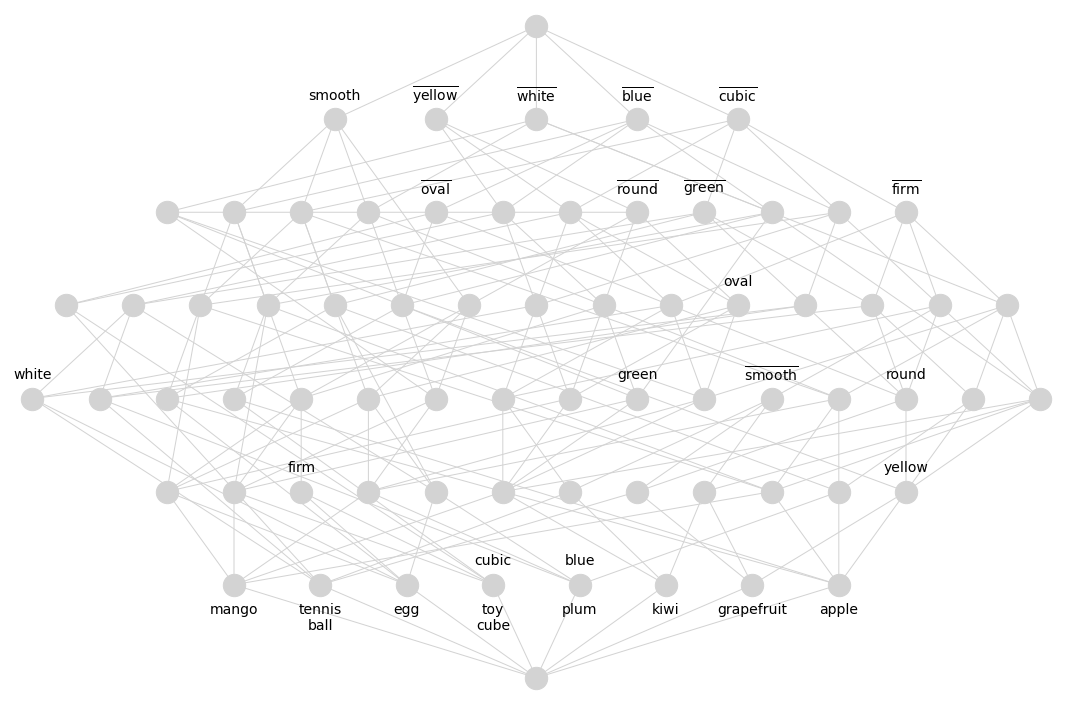

In [16]:
plt.figure(figsize=(15,10))

vsl = ConceptLatticeVisualizer(L, **dict(VSL_PARAMS, node_size=500, label_font_size=14))
levels_dict = vsl._calc_levels()[1]
for node_i, x in zip(levels_dict[1][::-1], np.linspace(-0.4, 0.4, len(levels_dict[1]))):
    vsl._pos[node_i][0] = x
for node_i, x in zip(levels_dict[6][::-1], np.linspace(-0.6, 0.6, len(levels_dict[6]))):
    vsl._pos[node_i][0] = x
plt.axis('off')
plt.xlim(-1.05,1.05)
plt.ylim(-0.49, 0.51)
vsl.draw_networkx(draw_node_indices=False, draw_new_extent_len=False, draw_new_intent_len=False, label_func=lambda c_i: concept_label_func(vsl, c_i))
plt.tight_layout()
plt.savefig('Concept_lattice.eps', dpi=1200,)
plt.show()

# 3 Decision Based models in Theory

## 3.1 Decision rule

In [17]:
from decision_poset_structure import DecisionRule

In [18]:
premise = ['form_is_round']
target = K_df.loc[K.extension(premise), 'fruit'].mean()
drule = DecisionRule(premise, target)
drule

DecisionRule(['form_is_round'],0.6666666666666666)

## 3.2 Decision poset

In [19]:
def premise_verb(premise):
    if len(premise) > 0:
        premise = [re.sub(r'[^_]+_is_', '', m) for m in premise]
        premise = [m.replace('_', ' ') for m in premise]
        premise = ['$\overline{\mathrm{'+m[4:].replace(' ','\ ')+'}}$' if m.startswith('not ') else m for m in premise]
    else:
        premise = ['$\emptyset$']
    return premise

In [20]:
def label_func(el_i, DP):
    el = DP[el_i]
    premise = premise_verb(el.premise)
    return '\n\n\n'.join([', '.join(premise), f"{el.target:.2f}"])

In [21]:
def draw_decision_poset(
    dp, vsl_params, draw_node_indices=False, label_func=None, ax=None,
    dx_coefs=(0,0), dy_coefs=(0,0), nodes_dx=None, nodes_dy=None, nodes_pos=None,
    off_axis=True,
):    
    if ax is None:
        fig, ax = plt.subplots()
        
    nodes_dx = nodes_dx if nodes_dx is not None else {}
    nodes_dy = nodes_dy if nodes_dy is not None else {}
    nodes_pos = nodes_pos if nodes_pos is not None else {}
        
    dp_vsl = POSetVisualizer(dp, **vsl_params)
    for n_i, pos in nodes_pos.items():
        dp_vsl._pos[n_i] = pos
    for n_i, dx in nodes_dx.items():
        dp_vsl._pos[n_i][0] += dx
    for n_i, dy in nodes_dy.items():
        dp_vsl._pos[n_i][1] += dy
    
    
    dp_vsl.draw_networkx(
        draw_node_indices=draw_node_indices, ax=ax,
        label_func=(lambda el_i: label_func(el_i, dp)) if label_func is not None else None,
    )
    xmin, xmax = ax.get_xlim()
    dx = xmax-xmin
    xmin, xmax = xmin-dx*dx_coefs[0], xmax+dx*dx_coefs[1]
    
    ymin, ymax = ax.get_ylim()
    dy = ymax-ymin
    ymin, ymax = ymin-dy*dy_coefs[0], ymax+dy*dy_coefs[1]
    
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    if off_axis:
        ax.set_axis_off()

In [22]:
from decision_poset_structure import DecisionRule, DecisionPOSet, compare_set_function

In [23]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

In [24]:
X = K_X.to_pandas().astype(int)
y = K_df['fruit']

In [25]:
premises = [('not_firm',), ('not_firm', 'not_color_is_white'), ('not_firm', 'color_is_white')]#('not_firm','color_is_yellow')]
p = premises[0]
drules = [DecisionRule(p, y[K_X_dich.extension(p)].mean()) for p in premises]
drules

[DecisionRule(('not_firm',),0.8333333333333334),
 DecisionRule(('not_firm', 'not_color_is_white'),1.0),
 DecisionRule(('not_firm', 'color_is_white'),0.0)]

In [26]:
DP1 = DecisionPOSet(premises=premises, targets=[y[K_X_dich.extension(p)].mean() for p in premises], leq_premise_func=compare_set_function)

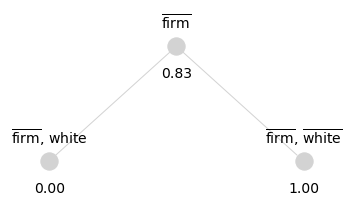

In [27]:
fig, ax = plt.subplots()
fig.set_size_inches(5, 3)

draw_decision_poset(
    DP1, VSL_PARAMS, draw_node_indices=False, label_func=label_func, ax=ax,
    dx_coefs=(0.05, 0.05), dy_coefs=(0.2,0.2), off_axis=True)

DP1_vsl = POSetVisualizer(DP1, **VSL_PARAMS)

#plt.title('Example of Decision Poset', size=18)
plt.tight_layout()
plt.savefig('Decision_poset_example.eps', dpi=1200)
plt.show()

In [28]:
DP1_vsl._calc_levels()

([0, 1, 1], {0: [0], 1: [1, 2]})

In [29]:
DP1.top_elements

[0]

In [30]:
DP1.sub_elements_dict

{0: {1, 2}, 1: set(), 2: set()}

## 3.3 Operations on decision poset

In [31]:
K[(K_X_dich.extension_i([K_X_dich.attribute_names.index(m) for m in ['not_color_is_white']]))]

FormalContext (6 objects, 10 attributes, 22 connections)
          |firm|smooth|fruit|color_is_yellow|color_is_green|color_is_blue|color_is_white|form_is_round|form_is_oval|form_is_cubic|
apple     |    |     X|    X|              X|              |             |              |            X|            |             |
grapefruit|    |      |    X|              X|              |             |              |            X|            |             |
kiwi      |    |      |    X|               |             X|             |              |             |           X|             |
plum      |    |     X|    X|               |              |            X|              |             |           X|             |
toy cube  |   X|     X|     |               |             X|             |              |             |            |            X|
mango     |    |     X|    X|               |             X|             |              |             |           X|             |

In [32]:
premises = [('not_color_is_white',),('not_firm', 'not_color_is_white',), ('not_firm',)]
drules = [DecisionRule(p, y[K_X_dich.extension(p)].mean()) for p in premises]
drules

[DecisionRule(('not_color_is_white',),0.8333333333333334),
 DecisionRule(('not_firm', 'not_color_is_white'),1.0),
 DecisionRule(('not_firm',),0.8333333333333334)]

In [33]:
DP2 = DecisionPOSet(premises=premises, targets=[y[K_X_dich.extension(p)].mean() for p in premises], leq_premise_func=compare_set_function)

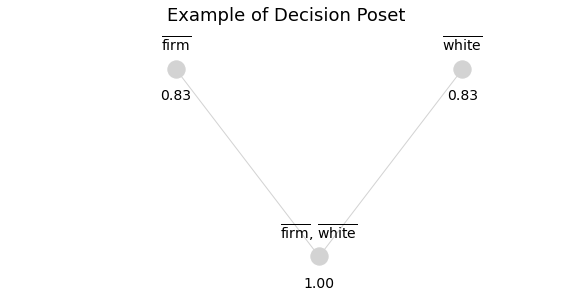

In [34]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)

draw_decision_poset(
    DP2, VSL_PARAMS, draw_node_indices=False, label_func=label_func,ax=ax,
    dx_coefs=[0.4, 0.21], dy_coefs=[0.1, 0.1],
)
ax.set_title('Example of Decision Poset', size=18)
plt.show()

In [35]:
DP_sum = DP1+DP2

In [36]:
DP_mean = DP_sum*0.5

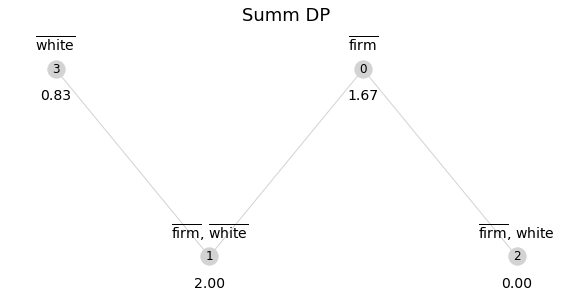

In [37]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)

draw_decision_poset(
    DP_sum, VSL_PARAMS, draw_node_indices=True, label_func=label_func, ax=ax,
    dy_coefs=(0.1, 0.1),
    nodes_dx={2: 3, 1: -1}
)
plt.title('Summ DP', size=18)
plt.show()

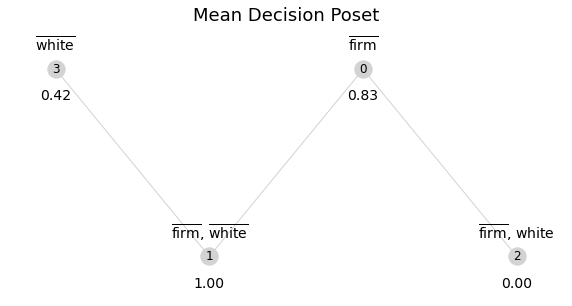

In [38]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)

draw_decision_poset(
    DP_mean, VSL_PARAMS, draw_node_indices=True, label_func=label_func, ax=ax,
    dy_coefs=(0.1, 0.1),
    nodes_dx={2: 3, 1: -1}
)
plt.title('Mean Decision Poset', size=18)
plt.show()

Put it in one plot

In [39]:
import networkx as nx

In [40]:
from matplotlib import gridspec

In [41]:
clr1, clr2 = [c for c in plt.cm.tab10.colors[:2]]
clr2 = (0.87, 0.87, 0.87 )
clr1, clr2 = clr2, clr1
clr_mean = tuple((np.array(clr1)+np.array(clr2))/2)

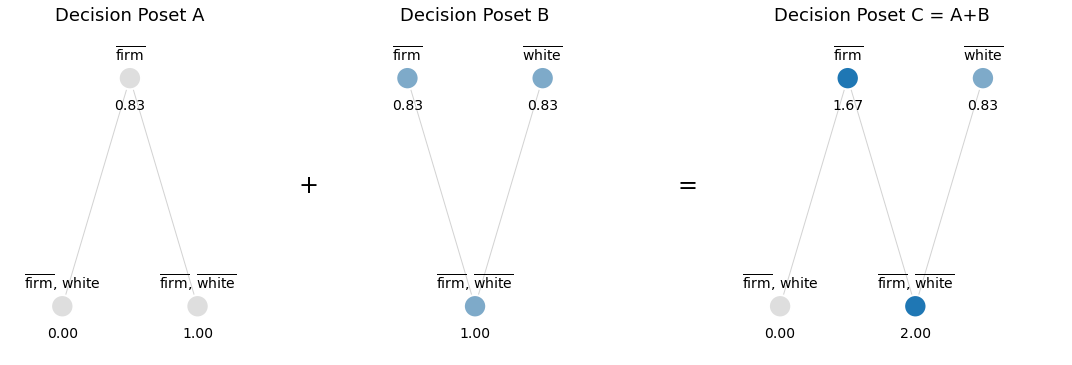

In [42]:
fig = plt.figure(figsize=(15,5))

gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1.5]) 
axes = [plt.subplot(gs[i]) for i in range(3)]

DPS = [DP1, DP2, DP_sum] # DP_mean]
titles = ['Decision Poset A', 'Decision Poset B', 'Decision Poset C = A+B']
nodes_poss = [{0: (0, 1), 1: (1, 0), 2: (-1, 0)}, {0: (1, 1), 1: (0, 0), 2: (-1, 1)},  {0: (1, 1), 1: (2, 0), 2: (0, 0), 3: (3, 1)},]
#node_colors_set = [[clr1]*3, [clr2]*3, [clr_mean, clr_mean, clr1, clr2]]
node_colors_set = [[clr1]*3, [clr_mean]*3, [clr2, clr2, clr1, clr_mean]]
node_edgecolors_set = ['white']*4

for ax_i, ax in enumerate(axes):
    draw_decision_poset(
        DPS[ax_i],
        dict(VSL_PARAMS, node_color=node_colors_set[ax_i], node_edgecolor=node_edgecolors_set[ax_i],
             node_linewidth=2, node_size=500),
        ax=ax, 
        draw_node_indices=False,
        label_func=label_func, dy_coefs=(0.1, 0.1), dx_coefs=(0.25,0.25),
        nodes_pos=nodes_poss[ax_i], off_axis=True,
    )
    ax.set_title(titles[ax_i], size=18,)
    #ax.set_xlabel(titles[ax_i])
    
axes[0].text(2.5, 0.5, '+', size=24)
axes[1].text(3, 0.5, '=', size=24)
    
plt.tight_layout()
plt.subplots_adjust(top=0.95)
#plt.suptitle('Summation of Decision Posets', size=18)
plt.savefig('DP_summation.eps', dpi=1200)
plt.show()

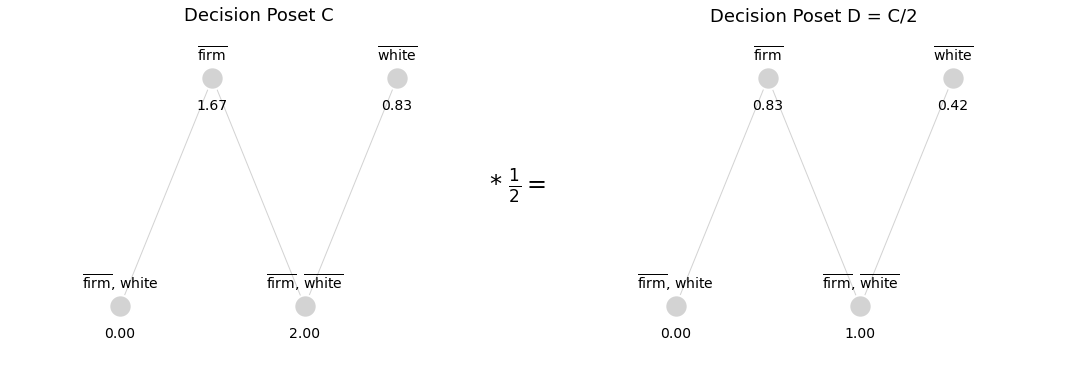

In [43]:
fig = plt.figure(figsize=(15,5))

gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 
axes = [plt.subplot(gs[i]) for i in range(2)]

DPS = [DP_sum, DP_mean]
titles = ['Decision Poset C', 'Decision Poset D = C/2']
nodes_poss = [{0: (1, 1), 1: (2, 0), 2: (0, 0), 3: (3, 1)}]*2
node_colors_set = ['lightgrey']*2 # [[clr_mean, clr_mean, clr1, clr2]]*2

node_edgecolors_set = ['white']*4

for ax_i, ax in enumerate(axes):
    draw_decision_poset(
        DPS[ax_i],
        dict(VSL_PARAMS, node_color=node_colors_set[ax_i], node_edgecolor=node_edgecolors_set[ax_i],
             node_linewidth=2, node_size=500),
        ax=ax, 
        draw_node_indices=False,
        label_func=label_func, dy_coefs=(0.1, 0.1), dx_coefs=(0.25,0.25),
        nodes_pos=nodes_poss[ax_i], off_axis=True,
    )
    ax.set_title(titles[ax_i], size=18,)
    #ax.set_xlabel(titles[ax_i])
    
#axes[0].text(4, 0.5, '* 0.5 =', size=24)
axes[0].text(4, 0.5, r'* $\frac{1}{2} =$', size=24)
#axes[1].text(3, 0.5, '=', size=24)
    
plt.tight_layout()
plt.subplots_adjust(top=0.95)
#plt.suptitle('Multiplication of Decision Poset by a number', size=18)
plt.savefig('DP_mult.eps', dpi=1200)
plt.show()

## 3.4 Decision semilattice

In [44]:
from decision_poset_structure import DecisionSemiLattice

In [45]:
premises = [tuple([]), ('not_firm',), ('not_firm', 'not_color_is_white'), ('not_firm','color_is_white'), ('not_color_is_white',)]
drules = [DecisionRule(p, y[K_X_dich.extension(p)].mean()) for p in premises]
drules

[DecisionRule((),0.625),
 DecisionRule(('not_firm',),0.8333333333333334),
 DecisionRule(('not_firm', 'not_color_is_white'),1.0),
 DecisionRule(('not_firm', 'color_is_white'),0.0),
 DecisionRule(('not_color_is_white',),0.8333333333333334)]

In [46]:
DSL1 = DecisionPOSet(premises=premises, targets=[y[K_X_dich.extension(p)].mean() for p in premises], leq_premise_func=compare_set_function)

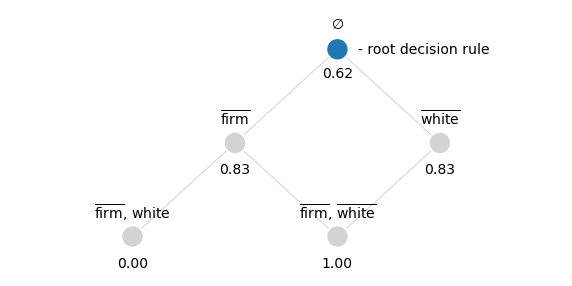

In [47]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)

draw_decision_poset(
    DSL1,
    dict(
        VSL_PARAMS,
        node_color=[clr2 if el_i==0 else 'lightgrey' for el_i in range(len(DSL1))],
        node_edgecolor='white',
        node_linewidth=2, node_size=500,
    ),
    draw_node_indices=False,
    ax=ax,
    label_func=label_func, dy_coefs=(0.1, 0.1), dx_coefs=(0.25,0.25),
    #nodes_pos=nodes_poss[ax_i],
    off_axis=True,
    nodes_pos=({0: (0, 1), 4: (1, 0), 1: (-1, 0), 3: (-2, -1), 2: (0, -1)})
    #nodes_dx={3: 0.83+0.4, 2: -0.4}
)
plt.text(0.2, 1-0.05, '- root decision rule', size=14)
#ax.set_title('Decision Semilattice', size=18)
plt.savefig('Decision_semilattice.eps', dpi=1200)
plt.show()

## 3.5 Decision Tree

In [148]:
from decision_poset_structure import DecisionSemiLattice

In [149]:
#premises = [tuple([]), ('not_firm',), ('not_firm', 'not_color_is_white'), ('not_firm','color_is_yellow')]
premises = [tuple([]), ('not_firm',), ('not_firm', 'color_is_white'), ('not_firm', 'not_color_is_white'), ('firm',) ]
drules = [DecisionRule(p, y[K_X_dich.extension(p)].mean()) for p in premises]
drules

[DecisionRule((),0.625),
 DecisionRule(('not_firm',),0.8333333333333334),
 DecisionRule(('not_firm', 'color_is_white'),0.0),
 DecisionRule(('not_firm', 'not_color_is_white'),1.0),
 DecisionRule(('firm',),0.0)]

In [150]:
DT1 = DecisionPOSet(premises=premises, targets=[y[K_X_dich.extension(p)].mean() for p in premises], leq_premise_func=compare_set_function)

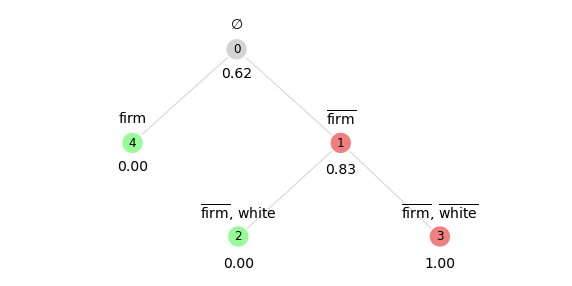

In [151]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)

draw_decision_poset(
    DT1,
    dict(
        VSL_PARAMS,
        node_color=['palegreen' if el_i in {4, 2} else 'lightcoral' if el_i in {1, 3} else 'lightgrey' for el_i in range(len(DT1))],
        node_edgecolor='white',
        node_linewidth=2, node_size=500
    ),
    draw_node_indices=True,
    ax=ax,
    label_func=label_func, dy_coefs=(0.1, 0.1), dx_coefs=(0.25,0.25),
    #nodes_pos=nodes_poss[ax_i],
    off_axis=True,
    nodes_dx={3: 0.83+0.4, 2: -0.41}
)
#ax.set_title('Decision Tree', size=18)
plt.savefig('Decision_tree.eps', dpi=1200)
plt.show()

## 3.6 Absolute and differential paradigms

In [152]:
def label_func_diff(el_i, DP_diff, DP=None):
    el = DP_diff[el_i]
    premise = el.premise
    if len(premise) > 0:
        premise = [re.sub(r'[^_]+_is_', '', m) for m in premise]
        premise = [m.replace('_', ' ') for m in premise]
        premise = ['$\overline{\mathrm{'+m[4:].replace(' ','\ ')+'}}$' if m.startswith('not ') else m for m in premise]
        premise = ', '.join(premise)
    else:
        premise = '$\emptyset$'
    
    target = el.target
    target = ('+' if target>=0 else '-') + f"{abs(target):.2f}"
    
    if DP is not None:
        abs_target = DP.targets[el_i]
        target += '\n ' + r'$\left( \sum '+f"{abs_target:.2f}"+r' \right) $'
        premise = '\n'+premise
    
    return '\n\n\n'.join([premise, target])

In [153]:
DT1_diff = DT1.differentiate()

In [154]:
draw_decision_poset

<function __main__.draw_decision_poset(dp, vsl_params, draw_node_indices=False, label_func=None, ax=None, dx_coefs=(0, 0), dy_coefs=(0, 0), nodes_dx=None, nodes_dy=None, nodes_pos=None, off_axis=True)>

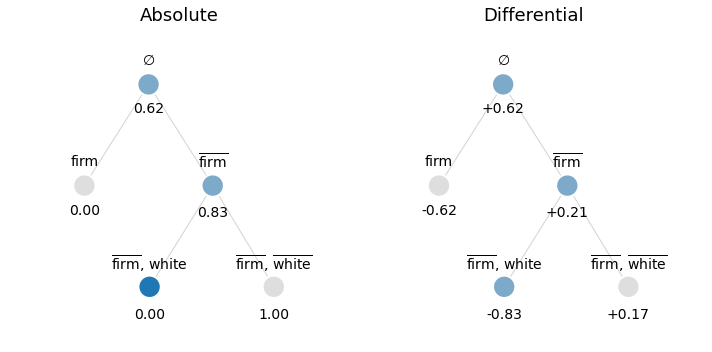

In [155]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 5)

DTS = [DT1, DT1_diff]
#label_funcs = [label_func, lambda el_i, DP_diff: label_func_diff(el_i, DP_diff, DT1)]
label_funcs = [label_func, label_func_diff]
titles = ['Absolute', 'Differential']

node_edgecolors_set = ['white', 'white']
node_colors_set = [
    #['lightblue', 'lightblue', 'lightblue', 'lightgrey', 'lightgrey'],
    [clr_mean, clr_mean, clr2, clr1, clr1],
    [clr_mean, clr_mean, clr_mean, clr1, clr1],
]

for ax_i, ax in enumerate(axes):
    draw_decision_poset(
        DTS[ax_i],
        dict(VSL_PARAMS, node_linewidth=2, node_size=500, node_color=node_colors_set[ax_i], node_edgecolor=node_edgecolors_set[ax_i]),
        draw_node_indices=False,
        ax=ax,
        label_func=label_funcs[ax_i], dy_coefs=(0.15, 0.15), dx_coefs=(0.25,0.25),
        #nodes_pos=nodes_poss[ax_i],
        off_axis=True,
        nodes_dx={3: 0.83+0.4, 2: -0.41},
    )
    ax.set_title(titles[ax_i], size=18)
    
#axes[0].text(1.5, 0, r'$\sim$', size=24)

plt.tight_layout()
plt.savefig('Decision_tree_abs_and_diff.eps', dpi=1200)
plt.show()

## 3.7 Models definition

In [156]:
models_df = pd.DataFrame(
    [[r'$\mathcal{DSL}$', r'$\mathcal{DSL}^\Delta$'],
     [r'$\mathcal{DT}$', r'$\mathcal{DT}^\Delta$']],
    index=['Decision SemiLattice', 'Decision Tree'],
    columns=['Absolute', 'Differential']
)
models_df

,Absolute,Differential
Decision SemiLattice,$\mathcal{DSL}$,$\mathcal{DSL}^\Delta$
Decision Tree,$\mathcal{DT}$,$\mathcal{DT}^\Delta$


In [157]:
print(models_df.to_latex())

\begin{tabular}{lll}
\toprule
{} &         Absolute &            Differential \\
\midrule
Decision SemiLattice &  \$\textbackslash mathcal\{DSL\}\$ &  \$\textbackslash mathcal\{DSL\}\textasciicircum \textbackslash Delta\$ \\
Decision Tree        &   \$\textbackslash mathcal\{DT\}\$ &   \$\textbackslash mathcal\{DT\}\textasciicircum \textbackslash Delta\$ \\
\bottomrule
\end{tabular}



## 3.8 Conversion between absolute and differential models

In [185]:
def label_func_diff_obv(el_i, DP_diff, DP=None):
    el = DP_diff[el_i]
    premise = el.premise
    if len(premise) > 0:
        premise = [re.sub(r'[^_]+_is_', '', m) for m in premise]
        premise = [m.replace('_', ' ') for m in premise]
        premise = ['$\overline{\mathrm{'+m[4:].replace(' ','\ ')+'}}$' if m.startswith('not ') else m for m in premise]
        premise = ', '.join(premise)
    else:
        premise = '$\emptyset$'
    
    target = el.target
    target = ('+' if target>=0 else '-') + f"{abs(target):.2f}"
    
    if DP is not None and el_i != DP_diff.top_elements[0]:
        parent_i = list(DP_diff.direct_super_elements(el_i))[0]
        #target += f"\n= {DP[el_i].target:.2f} - {DP[parent_i].target:.2f}"
        target = f"{DP[el_i].target:.2f} - {DP[parent_i].target:.2f}\n= "+target
        
        premise = '\n'+premise
        #abs_target = DP.targets[el_i]
        #    
        #target += '\n ' + r'$\left( \sum '+f"{abs_target:.2f}"+r' \right) $'
        
    
    return '\n\n\n'.join([premise, target])

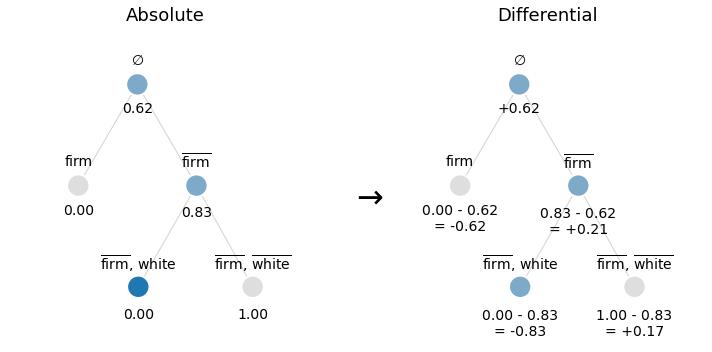

In [192]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 5)

DTS = [DT1, DT1_diff]
#label_funcs = [label_func, lambda el_i, DP_diff: label_func_diff(el_i, DP_diff, DT1)]
label_funcs = [label_func, lambda el_i, DP: label_func_diff_obv(el_i, DP, DT1)]
titles = ['Absolute', 'Differential']

node_colors_set = [
    #['lightblue', 'lightblue', 'lightblue', 'lightgrey', 'lightgrey'],
    [clr_mean, clr_mean, clr2, clr1, clr1],
    [clr_mean, clr_mean, clr_mean, clr1, clr1],
]


for ax_i, ax in enumerate(axes):
    draw_decision_poset(
        DTS[ax_i],
        dict(VSL_PARAMS, node_linewidth=2, node_size=500, 
             node_color=node_colors_set[ax_i],
             node_edgecolor='white'),
        draw_node_indices=False,
        ax=ax,
        label_func=label_funcs[ax_i], dy_coefs=(0.15, 0.15), dx_coefs=(0.25,0.25),
        #nodes_pos=nodes_poss[ax_i],
        off_axis=True,
        nodes_dx={3: 0.83+0.4, 2: -0.41}
    )
    ax.set_title(titles[ax_i], size=18)
    
axes[0].text(1.5, 0, r'$\rightarrow$', size=32)
    
plt.tight_layout()
plt.savefig('Convert_abs_diff_colored.eps', dpi=1200)
plt.show()

## 3.9 Summation of differential decision based models

In [89]:
premises1 = [tuple([]), ('firm',), ('not_firm',), ]#('not_firm', 'color_is_white'), ('not_firm','not_color_is_white')]
premises2 = [tuple([]), ('color_is_white',), ('not_color_is_white',),]# ('not_color_is_white', 'form_is_cubic'), ('not_color_is_white','not_form_is_cubic')]

DT1 = DecisionPOSet(premises=premises1, targets=[y[K_X_dich.extension(p)].mean() for p in premises1], leq_premise_func=compare_set_function)
DT2 = DecisionPOSet(premises=premises2, targets=[y[K_X_dich.extension(p)].mean() for p in premises2], leq_premise_func=compare_set_function)

DT1_diff = DT1.differentiate()
DT2_diff = DT2.differentiate()

In [90]:
DSL_sum = DT1_diff+DT2_diff

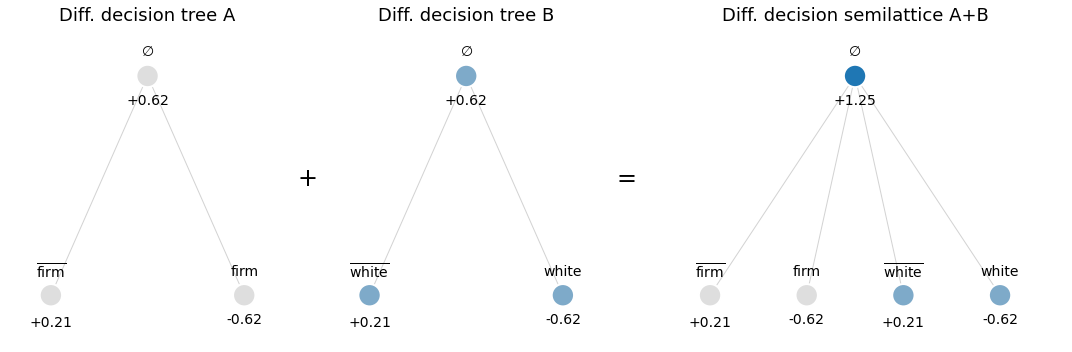

In [142]:
fig = plt.figure(figsize=(15,5))

gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1.5]) 
axes = [plt.subplot(gs[i]) for i in range(3)]

DPS = [DT1_diff, DT2_diff, DSL_sum]
titles = ['Diff. decision tree A', 'Diff. decision tree B', 'Diff. decision semilattice A+B']
#nodes_poss = [{0: (0, 1), 1: (1, 0), 2: (-1, 0)}, {0: (1, 1), 1: (0, 0), 2: (-1, 1)},  {0: (1, 1), 1: (2, 0), 2: (0, 0), 3: (3, 1)},]
#node_colors_set = [[clr1]*3, [clr2]*3, [clr_mean, clr_mean, clr1, clr2]]
#node_colors_set = [[clr1]*3, [clr_mean]*3, [clr2, clr2, clr1, clr_mean]]
#node_colors_set = ['lightgrey']*3
node_colors_set = [
    [clr2 if el_i in {0,2} else clr1 for el_i in range(len(DT1_diff))],
    [clr2 if el_i in {0,2} else clr1 for el_i in range(len(DT2_diff))],
    [clr2 if el_i in {0,2, 4} else clr1 for el_i in range(len(DSL_sum))],
]
node_colors_set = [
    [clr1]*len(DT1_diff),
    [clr_mean]*len(DT2_diff),
    [clr2 if el_i==0 else clr_mean if el_i in {3, 4} else clr1 for el_i in range(len(DSL_sum))]
]
node_edgecolors_set = ['white']*3

nodes_poss = [{0: (0, 1), 1: (1, 0), 2: (-1, 0)}, {0: (0, 1), 1: (1, 0), 2: (-1, 0)}, {0: (0, 1), 2: (-1.5, 0), 1: (-0.5, 0), 4: (0.5, 0), 3: (1.5, 0)}]

for ax_i, ax in enumerate(axes):
    draw_decision_poset(
        DPS[ax_i],
        dict(VSL_PARAMS, node_color=node_colors_set[ax_i], node_edgecolor=node_edgecolors_set[ax_i],
             node_linewidth=2, node_size=500),
        ax=ax, 
        draw_node_indices=False,
        label_func=label_func_diff, dy_coefs=(0.1, 0.1), dx_coefs=(0.1,0.1),
        nodes_pos=nodes_poss[ax_i],
        off_axis=True,
    )
    ax.set_title(titles[ax_i], size=18,)
    #ax.set_xlabel(titles[ax_i])
    
axes[0].text(1.55, 0.5, '+', size=24)
axes[1].text(1.55, 0.5, '=', size=24)

    
plt.tight_layout()
#plt.subplots_adjust(top=0.95)
#plt.suptitle('Summation of Decision Posets', size=18)
plt.savefig('DT_diff_summation.eps', dpi=1200)
plt.show()

## 3.10 Connection with Random Forest and Gradient Boosting

# 4 Decision based models in practice

## 4.1 Class of equivalent premises

In [489]:
premise = ('not_color_is_white', 'not_form_is_cubic')
int_ = K_X_dich.intention(K_X_dich.extension(premise))

In [493]:
premise = ('color_is_white', 'not_firm')
int_ = K_X_dich.intention(K_X_dich.extension(premise))
int_

['color_is_white',
 'form_is_round',
 'not_firm',
 'not_smooth',
 'not_color_is_yellow',
 'not_color_is_green',
 'not_color_is_blue',
 'not_form_is_oval',
 'not_form_is_cubic']

In [494]:
K_X_dich.get_minimal_generators(int_)

[('form_is_round', 'not_color_is_yellow'),
 ('color_is_white', 'not_smooth'),
 ('color_is_white', 'not_form_is_oval'),
 ('color_is_white', 'form_is_round'),
 ('color_is_white', 'not_firm')]

In [510]:
premises = [tuple([]), ('form_is_round',), ('form_is_round', 'not_color_is_yellow'), ('not_smooth',), ('color_is_white', 'not_smooth'),]

In [511]:
DP = DecisionPOSet(premises=premises, targets=[y[K_X_dich.extension(p)].mean() for p in premises], leq_premise_func=compare_set_function)

In [512]:
def label_func_premise_extent(el_i, DP, K, max_ext_per_line=None):
    el = DP[el_i]
    premise = el.premise
    if len(premise) > 0:
        premise = [re.sub(r'[^_]+_is_', '', m) for m in premise]
        premise = [m.replace('_', ' ') for m in premise]
        premise = ['$\overline{\mathrm{'+m[4:].replace(' ','\ ')+'}}$' if m.startswith('not ') else m for m in premise]
    else:
        premise = ['$\emptyset$']
    premise = ', '.join(premise)
        
        
    new_ext = set(K.extension(DP[el_i].premise))
    for dsubel_i in DP.direct_sub_elements(el_i):
        new_ext -= set(K.extension(DP[dsubel_i].premise)) 
    
    ex_str = 'Ex.:'
    new_ext = [ex_str] + list(new_ext) 
    if max_ext_per_line is not None:
        new_ext = list(new_ext)
        new_ext_ = [ ', '.join(new_ext[i*max_ext_per_line:(i+1)*max_ext_per_line]) for i in range(len(new_ext)//max_ext_per_line+1) ]
        new_ext_[0] = new_ext_[0].replace(ex_str+',', ex_str)
        if new_ext_[-1] == '':
            new_ext_ = new_ext_[:-1]
        new_ext = ',\n'.join(new_ext_)
        new_ext = new_ext.strip(',')
    else:
        new_ext = ', '.join(list(new_ext))
    #new_ext = "ex: "+new_ext
        
    target = f"{el.target:.2f}"

    lower_label = '\n'.join([target, new_ext])
    upper_label = (len(re.findall('\n', lower_label))-0)*'\n'+premise
    

    
    return '\n\n\n'.join([upper_label, lower_label])

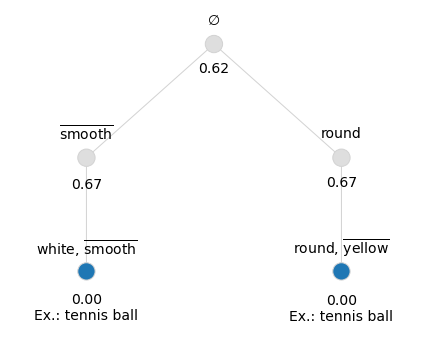

In [514]:
fig, ax = plt.subplots()
fig.set_size_inches(6, 5)

draw_decision_poset(
    DP,
    dict(VSL_PARAMS, node_color=[clr2 if n_i in {2, 4} else clr1 for n_i in range(len(DP))]),
    draw_node_indices=False,
    label_func = lambda el_i, DP: label_func_premise_extent(el_i, DP, K_X_dich, 3) if el_i in {2,4} else label_func(el_i, DP),
    ax=ax,
    dx_coefs=(0.17, 0.16), dy_coefs=(0.18,0.05), off_axis=True,   
)

#plt.text(-0.1, -0.5, r'$\sim$', size=24)
#plt.text(-0.1, -0.9, r'$=$', size=24)
#plt.text(-0.1, -0.4, r'$\neq$', size=24)

#plt.title('Example of Decision Poset', size=18)
plt.tight_layout()
#plt.xlim(-1,1)
plt.savefig('Equivalent_drules.eps', dpi=1200)
plt.show()

## 4.2 Decision quiver

In [517]:
extents = [
    K_X_dich.extension(p) for p in premises
    + [K_X_dich.attribute_names]
]
intents = [K_X_dich.intention(ext) for ext in extents]

extents_i = [[K_X_dich.object_names.index(g) for g in ext] for ext in extents]
intents_i = [[K_X_dich.attribute_names.index(m) for m in int_] for int_ in intents]

In [518]:
from fcapy.lattice.formal_concept import FormalConcept

In [519]:
concepts = list(set([FormalConcept(extents_i[c_i], extents[c_i], intents_i[c_i], intents[c_i]) for c_i in range(len(extents))]))
L = ConceptLattice(concepts)

In [520]:
int_i_map = {frozenset(c.intent): c_i for c_i, c in enumerate(L)}

In [521]:
decisions = {}
for drule_i, drule in enumerate(DP):
    int_ = frozenset(K_X_dich.intention(K_X_dich.extension(drule.premise)))
    c_i = int_i_map[int_]
    
    parent_i = DP.direct_super_elements(drule_i)
    
    if len(parent_i) == 0:
        direct_drule = (None, c_i, drule.premise)
        target = drule.target
    else:
        parent_i = list(parent_i)[0]
        parent_drule = DP[parent_i]
        
        parent_int = frozenset(K_X_dich.intention(K_X_dich.extension(parent_drule.premise)))
        parent_c_i = int_i_map[parent_int]
        
        direct_premise = tuple(set(drule.premise)-set(parent_drule.premise))
        target = drule.target - parent_drule.target
        
        direct_drule = (parent_c_i, c_i, direct_premise)
        
    decisions[direct_drule] = target

In [522]:
from fcapy.ml.decision_lattice import DecisionLatticeRegressor

In [523]:
dlr = DecisionLatticeRegressor(use_generators=True)
dlr._lattice = L
dlr._decisions = decisions

In [674]:
premise_verb(['form_is_round'])

['round']

In [679]:
def construct_decision_edges(dl):
    edges = {(v0 if v0 is not None else dl._lattice.top_concept_i, v1): (gen, dy)
         for (v0, v1, gen), dy in dl._decisions.items()}
    
    edges_verb = {}
    for edge, gen in edges.items():
        premise = premise_verb(gen[0])
        dy = gen[1]
        
        gen_verb = '\n'.join([', '.join(premise), f"{dy:.2f}"])
        
        edges_verb[edge] = gen_verb
    return edges, edges_verb

In [682]:
def label_func_concept(c_i, L, max_int_per_line=None, max_ext_per_line=None):
    c = L[c_i]
    intent_verb = ', '.join(premise_verb(c.intent))
    extent_verb = ', '.join(premise_verb(c.extent))
    
    if max_ext_per_line is not None:
        new_ext = extent_verb.split(', ')
        new_ext_ = [ ', '.join(new_ext[i*max_ext_per_line:(i+1)*max_ext_per_line]) for i in range(len(new_ext)//max_ext_per_line+1) ]
        new_ext_ = [g for g in new_ext_ if g != '']
        new_ext = ',\n'.join(new_ext_)
        extent_verb = new_ext.strip(',')
        
    if max_int_per_line is not None:
        new_int = intent_verb.split(', ')
        new_int_ = [ ', '.join(new_int[i*max_int_per_line:(i+1)*max_int_per_line]) for i in range(len(new_int)//max_int_per_line+1) ]
        new_int_ = [m for m in new_int_ if m != '']
        new_int = ',\n'.join(new_int_)
        new_int = new_int.strip(',')
        intent_verb = new_int
        
    intent_nlines, extent_nlines = len(intent_verb.split('\n')), len(extent_verb.split('\n'))
    max_nlines = max(intent_nlines, extent_nlines)
    
    intent_verb = '\n'*(max_nlines-intent_nlines) + intent_verb
    extent_verb = extent_verb + '\n'*(max_nlines-extent_nlines)
    
    #return '\n\n\n'.join([intent_verb, extent_verb])
    return '\n\n'.join([intent_verb, extent_verb])+'\n'

In [686]:
def draw_decision_lattice_as_pair(
    dl, L, xlim, ylim, supertitle, figsize, pos=None,
    max_attrs_per_line=None, max_objs_per_line=None,
    axis=None, bias_dx=0.07,
):
    node_labels = {c_i: f"{L.index(c)}" for c_i, c in enumerate(L) if c_i != L.bottom_concept_i}
    edges, edges_verb = construct_decision_edges(dl)
    
    G = dl.lattice.to_networkx()

    plt.figure(figsize=figsize)
    plt.subplot(1,2,1)
    vsl = ConceptLatticeVisualizer(L, **VSL_PARAMS)
    if pos is not None:
        vsl._pos = deepcopy(pos)
    
    vsl.draw_networkx(
        draw_bottom_concept=False, draw_node_indices=False,
        label_func=lambda c_i: label_func_concept(c_i, L, max_attrs_per_line, max_objs_per_line)
    )
    #nx.draw_networkx_labels(G, vsl._pos, labels=node_labels)

    plt.xlim(*xlim); plt.ylim(*ylim)
    if axis is not None:
        plt.axis(axis)
    #plt.title("Concept (Semi)Lattice", size=14, loc='left')
    plt.title("Concept Lattice", size=14, loc='left')


    plt.subplot(1,2,2)

    vsl.edge_color = 'white'
    vsl.draw_networkx(
        max_new_intent_count=0, max_new_extent_count=0, draw_bottom_concept=False,
        draw_new_extent_len=False, draw_new_intent_len=False,
    )
    #nx.draw_networkx_labels(G, vsl._pos, labels=node_labels)
    
    top_i = dl._lattice.top_concept_i

    nx.draw_networkx_edges(G, vsl._pos, edges_verb.keys(), edge_color='grey')
    nx.draw_networkx_edge_labels(G, vsl._pos, {k:v for k,v in edges_verb.items() if k != (top_i,top_i)}, rotate=False)
    nx.draw_networkx_labels(G, {top_i: np.array(vsl._pos[top_i])+np.array([bias_dx, top_i])},
                            {top_i:'$\emptyset$\n'+edges_verb[(top_i,top_i)].strip('\n')})
    plt.title('Decisions', size=14, loc='left')
    if axis is not None:
        plt.axis(axis)
    plt.xlim(*xlim); plt.ylim(*ylim)


    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.suptitle(supertitle, size=18)
    return vsl._pos

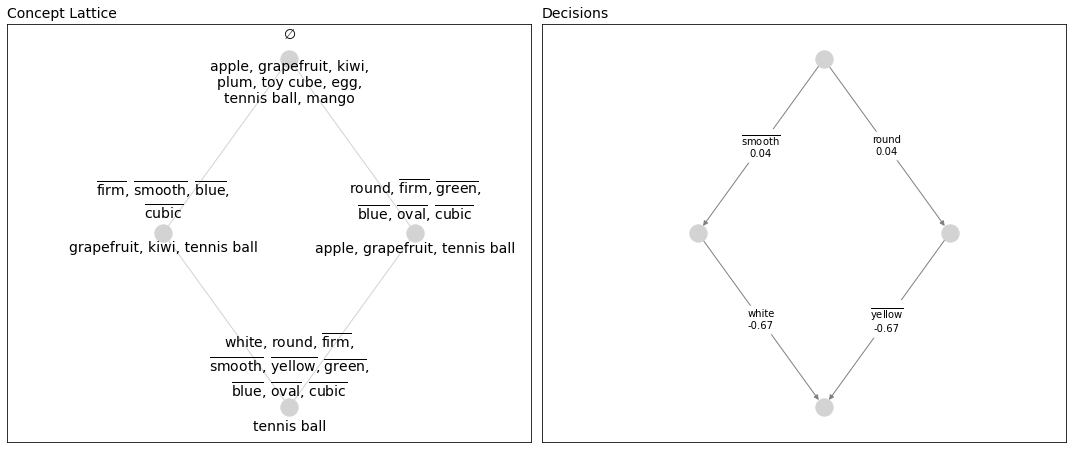

In [687]:
pos = draw_decision_lattice_as_pair(dlr, L, (-0.7, 0.6), (-0.5, 1), '', (15,7), bias_dx=0, max_attrs_per_line=3, max_objs_per_line=3)
plt.savefig('dquiver_example.eps', dpi=1200)

In [544]:
vsl.draw_networkx()

# 5 Experiments

## 5.1 Decision quiver as a common ground of ensembles of decision trees

## 5.2 Decision quiver is smaller than ensembles of decision trees

# 6. Conclusion

# 7. Future work

## 7.1 Visualization of ensembles of decision trees